In [1]:
# !pip install dataframe-image

In [2]:
# !pip install tabulate

In [3]:
# # to install the latest commit (from GitHub)
# !pip install git+https://github.com/garrettj403/SciencePlots

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

In [5]:
import scienceplots

In [6]:
# Making plots actually look nice
plt.style.use(['science', 'notebook', 'grid'])

In [7]:
# plt.style.available

In [8]:
from gammapy.datasets import FluxPointsDataset, Datasets
from gammapy.catalog import CATALOG_REGISTRY

In [9]:
import os
import sys
import importlib

modules_path = '../modules'

module_path = os.path.abspath(f'{modules_path}/spectral_models')
if module_path not in sys.path:
    sys.path.append(module_path)

import spectral_models
importlib.reload(spectral_models)
from spectral_models import pwl_model, get_source_data

module_path = os.path.abspath(f'{modules_path}/utilities')
if module_path not in sys.path:
    sys.path.append(module_path)

import utilities
importlib.reload(utilities)
from utilities import mkdir_sub_directory

In [10]:
from astropy import units as u

from gammapy.modeling import Fit
from gammapy.modeling.models import (
    Models,
    SuperExpCutoffPowerLaw4FGLDR3SpectralModel,
    ExpCutoffPowerLawSpectralModel,
    LogParabolaSpectralModel,
    PowerLawSpectralModel,
    SkyModel,
)

In [11]:
def source_identification(src_index = None):
    '''
    To write Docstring!!!!
    '''
    try: 
        
        global LHAASO_name, LHAASO_txt 
        
        LHAASO_name = df_fp["LHAASO_name"][src_index]
        LHAASO_txt = df_fp["LHAASO_txt"][src_index]
        
        global src_name, src_txt
        
        src_name = df_fp["source_name"][src_index]
        src_txt = df_fp["source_txt"][src_index] 
    
    except:
        print("Oops!  That was no valid index.  Try again...")

In [12]:
# import pandas library as pd

import pandas as pd 
from gammapy.datasets import FluxPointsDataset
from gammapy.catalog import CATALOG_REGISTRY
import os
import sys

format_csv = ".csv"
format_fits = ".fits"

sed_type="e2dnde"
# sed_type="dnde"

df_columns=[]
ds_fp = []
source_cat = []
  
# create an Empty DataFrame object
df = pd.DataFrame()


def getting_source_data(dict_lhaaso_tevc = None, catalog_tags = None):
    '''
    To write Docstring!!!!
    '''
    
    LHAASO_range = range(len(dict_lhaaso_tevc.keys()))
    for i in LHAASO_range:

        LHAASO_name = list(dict_lhaaso_tevc.keys())[i]
        LHAASO_txt = LHAASO_name.replace(" ", "")
        
        source_range = range(len(dict_lhaaso_tevc[LHAASO_name]))
        for j in source_range:

            cat_src = []

            cat_src_fp = []
            
            src_cat = []

            src_ds = []

            src_name = dict_lhaaso_tevc[LHAASO_name][j]
            src_txt = src_name.replace(" ", "")
            
            catalog_range = range(len(catalog_tags))
            for k in catalog_range: 
                
                catalog_tag = catalog_tags[k]
                catalog = CATALOG_REGISTRY.get_cls(catalog_tag)()
                
                try:
                    
                    src = catalog[src_name]
                    
                    cat_src.append(catalog_tag)
                    
                    ds_name = f"{src_name}: {catalog_tag}"
                    ds = FluxPointsDataset(
                        models = src.sky_model(),
                        data=src.flux_points, 
                        name=  ds_name     
                    )
                    
                    src_cat.append(src)
                    src_ds.append(ds)
                    cat_src_fp.append(catalog_tag)

                    table = ds.data.to_table(
                        sed_type = sed_type, 
                        formatted = True
                    )
                    
                    # Setting the units

                    
                    # Writes the flux points table in the fits format
                    file_name = f'{LHAASO_txt}_{src_txt}_{catalog_tag}{format_fits}'
                    path_os = os.path.abspath(
                        os.path.join(
                            f"{path_flux_points_tables}/{file_name}"
                        )
                    )      
                    
                    if path_os not in sys.path:
                        sys.path.append(path_os)

                    table.write(
                        f"{path_os}",
                        format = 'fits', 
                        overwrite = True
                    )
                    
                    # Writes the flux points table in the csv format
                    file_name = f'{LHAASO_txt}_{src_txt}_{catalog_tag}{format_csv}'
                    path_os = os.path.abspath(
                        os.path.join(
                            f"{path_flux_points_tables}/{file_name}"
                        )
                    )
                     
                    if path_os not in sys.path:
                        sys.path.append(path_os)

                    table.write(
                        f"{path_os}",
                        format = 'ascii.ecsv', 
                        overwrite = True
                    )   
                    
                except:
                    pass

                df_columns_k = [LHAASO_name, LHAASO_txt, src_name, src_txt, cat_src, cat_src_fp]
            df_columns.append(df_columns_k)
            ds_fp.append(src_ds)
            source_cat.append(src_cat)

    df = pd.DataFrame(df_columns, columns = ['LHAASO_name', "LHAASO_txt",'source_name', "source_txt", 'catalog', 'flux_points']) 
    df_fp = df[df["flux_points"].str.len() != 0]
    df_fp = df_fp.reset_index(drop = True)
    df_fp.index.name = 'source_index'
    
    file_name = "data_frame_flux_points.csv"
    path_file = f"{os.getcwd()}/{file_name}"
    df_fp.to_csv(path_file, index = "True" )
    
    df_no_fp = df[df["flux_points"].str.len() == 0]
    df_no_fp = df_no_fp.reset_index(drop = True)
    df_no_fp.index.name = 'source_index'
    
    file_name = "data_frame_no_flux_points.csv"
    path_file = f"{os.getcwd()}/{file_name}"
    df_no_fp.to_csv(path_file, index = "True")
    print(f"Sources without flux points table: {list(df_no_fp['source_name'])}")
    
    source_cat[:] = list(filter(None, source_cat))
    ds_fp[:] = list(filter(None, ds_fp))
    
    return df_fp, ds_fp, source_cat

In [13]:
# from pandas import read_csv

# myData = read_csv(f"{os.getcwd()}/data_frame_flux_points.csv", index_col = None)
# myData

In [14]:
#to get the current working directory
directory = os.getcwd()

print(directory)

/home/gamma/Documents/GitHub/gammapy/gammapy-notebooks/0.20.1/simulations/LHAASO_J1825-1326/data_access_and_selection(DL3)


In [15]:
import os

In [16]:
path_DL3 = os.getcwd()
os.chdir('../')
path_LHAASO = os.getcwd()
os.chdir(path_DL3)

file_name = "paths.dat"
path_file = f"{path_LHAASO}/{file_name}"
    
with open(path_file, "w") as my_file: 
    my_file.write(f"{path_LHAASO} \n")
    my_file.write(f"{path_file} \n")
    my_file.write(f"{path_DL3} \n")

In [17]:
path_file

'/home/gamma/Documents/GitHub/gammapy/gammapy-notebooks/0.20.1/simulations/LHAASO_J1825-1326/paths.dat'

In [18]:
f"{os.getcwd()}/data_frame_no_flux_points.csv"

'/home/gamma/Documents/GitHub/gammapy/gammapy-notebooks/0.20.1/simulations/LHAASO_J1825-1326/data_access_and_selection(DL3)/data_frame_no_flux_points.csv'

## Data Access and Selection (DL3)

#### Catalogs
Loading the catalogs and sources to be studied

In [19]:
print(CATALOG_REGISTRY)

Registry
--------

SourceCatalogGammaCat: gamma-cat 
SourceCatalogHGPS    : hgps 
SourceCatalog2HWC    : 2hwc 
SourceCatalog3FGL    : 3fgl 
SourceCatalog4FGL    : 4fgl 
SourceCatalog2FHL    : 2fhl 
SourceCatalog3FHL    : 3fhl 
SourceCatalog3HWC    : 3hwc 



In [20]:
catalog_tags = ["gamma-cat", "hgps", "2hwc", "3fgl", "4fgl", "2fhl", "3fhl", "3hwc"] 

In [21]:
catalogs_cls = []

In [22]:
# Loading the source catalogs
catalog_gammacat = CATALOG_REGISTRY.get_cls("gamma-cat")()
catalogs_cls.append(catalog_gammacat)

catalog_hgps = CATALOG_REGISTRY.get_cls("hgps")()
catalogs_cls.append(catalog_hgps)

catalog_2hwc = CATALOG_REGISTRY.get_cls("2hwc")()
catalogs_cls.append(catalog_2hwc)

catalog_3fgl = CATALOG_REGISTRY.get_cls("3fgl")()
catalogs_cls.append(catalog_3fgl)

catalog_4fgl = CATALOG_REGISTRY.get_cls("4fgl")()
catalogs_cls.append(catalog_4fgl)

catalog_2fhl = CATALOG_REGISTRY.get_cls("2fhl")()
catalogs_cls.append(catalog_2fhl)

catalog_3fhl = CATALOG_REGISTRY.get_cls("3fhl")()
catalogs_cls.append(catalog_3fhl)

catalog_3hwc = CATALOG_REGISTRY.get_cls("3hwc")()
catalogs_cls.append(catalog_3hwc)

In [23]:
for catalog in catalogs_cls:
    print(f"{catalog.tag}: {catalog.description}")

gamma-cat: An open catalog of gamma-ray sources
hgps: H.E.S.S. Galactic plane survey (HGPS) source catalog
2hwc: 2HWC catalog from the HAWC observatory
3fgl: LAT 4-year point source catalog
4fgl: LAT 8-year point source catalog
2fhl: LAT second high-energy source catalog
3fhl: LAT third high-energy source catalog
3hwc: 3HWC catalog from the HAWC observatory


In [24]:
# Creating a dictionary of the Potential TeV Counterparts (dict values) 
# of the three most significant (excluding Crab) LHASSO observations (dict keys)
# see https://www.nature.com/articles/s41586-021-03498-z
dict_lhaaso_tevc = {
    "LHAASO J1825-1326": ["HESS J1825-137", "HESS J1826-130", "2HWC J1825-134"], 
    "LHAASO J1908+0621": ["MGRO J1908+06" , "HESS J1908+063", "ARGO J1907+0627", "VER J1907+062", "2HWC J1908+063"], 
    "LHAASO J2226+6057": ["VER J2227+608"  , "Boomerang"]
}

In [25]:
# Creating the directories to save the flux points tables from Gammapy catalogs
dir_flux_points_tables = "flux_points_tables"

path_flux_points_tables = mkdir_sub_directory(
    dir_flux_points_tables
)

Directory 'flux_points_tables' created


In [26]:
# Getting the data of the sources from the catalogs of the Gammapy package
df_fp, ds_fp, source_cat = getting_source_data(dict_lhaaso_tevc, catalog_tags)

Sources without flux points table: ['2HWC J1825-134', '2HWC J1908+063', 'VER J2227+608']


In [27]:
df_fp

,LHAASO_name,LHAASO_txt,source_name,source_txt,catalog,flux_points
source_index,,,,,,
0,LHAASO J1825-1326,LHAASOJ1825-1326,HESS J1825-137,HESSJ1825-137,"[gamma-cat, hgps, 3fgl, 4fgl, 2fhl, 3fhl]","[gamma-cat, hgps, 3fgl, 4fgl, 2fhl, 3fhl]"
1,LHAASO J1825-1326,LHAASOJ1825-1326,HESS J1826-130,HESSJ1826-130,"[gamma-cat, hgps, 4fgl, 3fhl]","[gamma-cat, hgps, 4fgl, 3fhl]"
2,LHAASO J1908+0621,LHAASOJ1908+0621,MGRO J1908+06,MGROJ1908+06,"[gamma-cat, 3fgl, 4fgl]","[gamma-cat, 3fgl, 4fgl]"
3,LHAASO J1908+0621,LHAASOJ1908+0621,HESS J1908+063,HESSJ1908+063,"[gamma-cat, hgps]","[gamma-cat, hgps]"
4,LHAASO J1908+0621,LHAASOJ1908+0621,ARGO J1907+0627,ARGOJ1907+0627,[gamma-cat],[gamma-cat]
5,LHAASO J1908+0621,LHAASOJ1908+0621,VER J1907+062,VERJ1907+062,[gamma-cat],[gamma-cat]
6,LHAASO J2226+6057,LHAASOJ2226+6057,Boomerang,Boomerang,"[3fgl, 4fgl]","[3fgl, 4fgl]"


In [28]:
print(df_fp.to_latex())

\begin{tabular}{lllllll}
\toprule
{} &        LHAASO\_name &        LHAASO\_txt &      source\_name &      source\_txt &                                    catalog &                                flux\_points \\
source\_index &                    &                   &                  &                 &                                            &                                            \\
\midrule
0            &  LHAASO J1825-1326 &  LHAASOJ1825-1326 &   HESS J1825-137 &   HESSJ1825-137 &  [gamma-cat, hgps, 3fgl, 4fgl, 2fhl, 3fhl] &  [gamma-cat, hgps, 3fgl, 4fgl, 2fhl, 3fhl] \\
1            &  LHAASO J1825-1326 &  LHAASOJ1825-1326 &   HESS J1826-130 &   HESSJ1826-130 &              [gamma-cat, hgps, 4fgl, 3fhl] &              [gamma-cat, hgps, 4fgl, 3fhl] \\
2            &  LHAASO J1908+0621 &  LHAASOJ1908+0621 &    MGRO J1908+06 &    MGROJ1908+06 &                    [gamma-cat, 3fgl, 4fgl] &                    [gamma-cat, 3fgl, 4fgl] \\
3            &  LHAASO J1908+0621 &  LHAA

/tmp/ipykernel_1323478/3000407973.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_fp.to_latex())


In [29]:
dir_plot_spectrum = "SED_from_catalogs"

path_plot_spectrum = mkdir_sub_directory(
    dir_plot_spectrum
)

Directory 'SED_from_catalogs' created


In [30]:
def plot_SED():
    plt.style.use(['science', 'notebook', 'grid'])

    plt.figure(figsize=(8,6))

    ax = spectral_model.plot(energy_bounds, sed_type="e2dnde")
    ax = spectral_model.plot_error(energy_bounds, sed_type="e2dnde")
    flux_points.plot(
        ax=ax,
        color=colors_tag, 
        sed_type="e2dnde"
    )
    ax.text(0.02, .94, LHAASO_name, transform=ax.transAxes, bbox=dict(facecolor='white', edgecolor='black'), size=13)

    ax.set_ylim(ylim)
    ax.set_xlim(energy_bounds)

    # plt.title(f"{LHAASO_name}: {src_name}")
    plt.legend([spectral_model_tag, "Error", f"{src_name} - {catalog_tag}"], facecolor='white', edgecolor='black',  loc='upper right', prop={'size': 8})
    plt.xlabel("Energy (TeV)")   
    plt.ylabel(r"$E^{2}$dN/dE (erg $cm^{-2}$ $s^{-1}$)")
    plt.savefig(file_path, bbox_inches='tight')
    
    plt.show()

In [31]:
energy_bounds = [1e-5, 1e3] * u.TeV
ylim = [1e-16, 1e-6]

In [32]:
colors_tags = ["b", "g", "r", "c", "m", "y", "k", "m"]

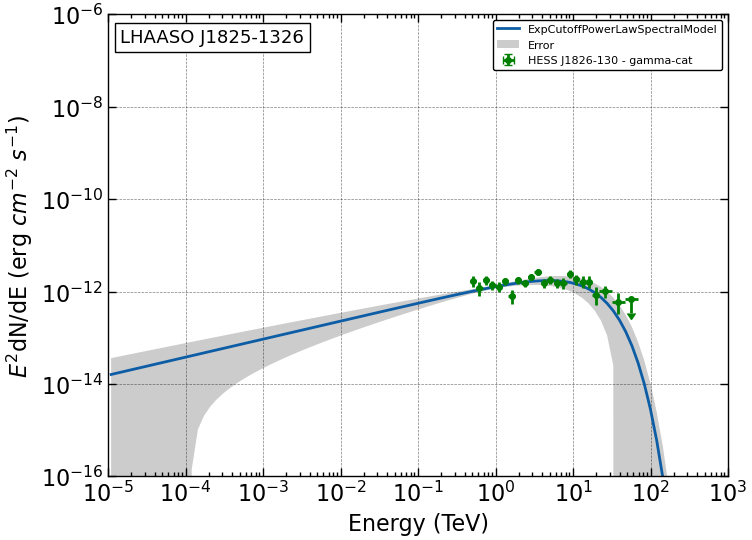

LHAASOJ1825-1326_HESSJ1826-130_gamma-cat_ExpCutoffPowerLawSpectralModel:
  type      name     value         unit      ... max frozen is_norm link
-------- --------- ---------- -------------- ... --- ------ ------- ----
spectral     index 1.6100e+00                ... nan  False   False     
spectral amplitude 8.6200e-13 cm-2 s-1 TeV-1 ... nan  False    True     
spectral reference 1.0000e+00            TeV ... nan   True   False     
spectral   lambda_ 8.0000e-02          TeV-1 ... nan  False   False     
spectral     alpha 1.0000e+00                ... nan   True   False     


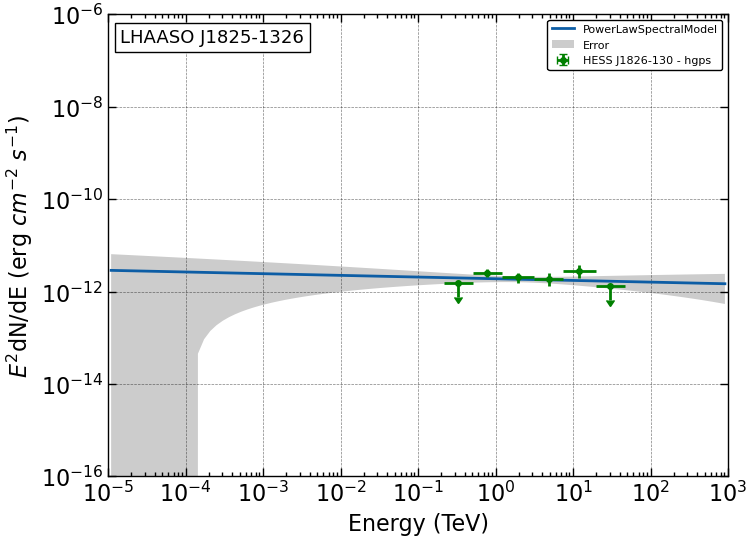

LHAASOJ1825-1326_HESSJ1826-130_hgps_PowerLawSpectralModel:
  type      name     value         unit      ... max frozen is_norm link
-------- --------- ---------- -------------- ... --- ------ ------- ----
spectral     index 2.0365e+00                ... nan  False   False     
spectral amplitude 2.7277e-13 cm-2 s-1 TeV-1 ... nan  False    True     
spectral reference 2.0559e+00            TeV ... nan   True   False     


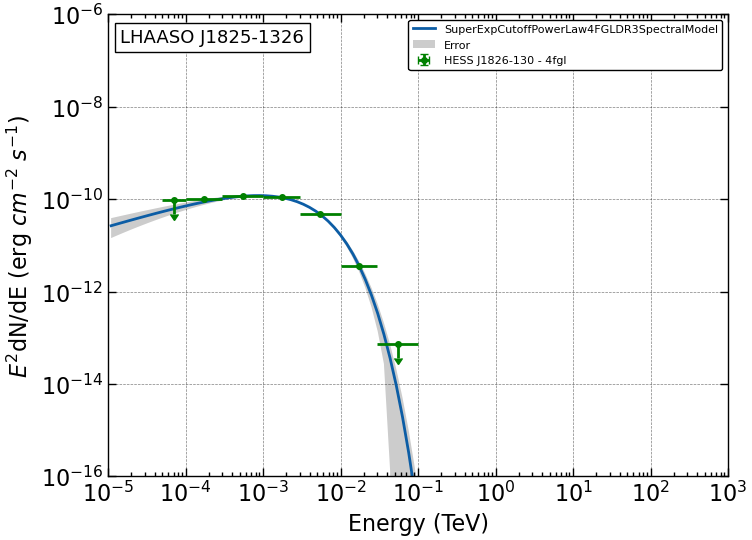

LHAASOJ1825-1326_HESSJ1826-130_4fgl_SuperExpCutoffPowerLaw4FGLDR3SpectralModel:
  type      name     value         unit      ... max frozen is_norm link
-------- --------- ---------- -------------- ... --- ------ ------- ----
spectral amplitude 1.2156e-11 cm-2 MeV-1 s-1 ... nan  False    True     
spectral reference 2.2472e+03            MeV ... nan   True   False     
spectral expfactor 6.6507e-01                ... nan  False   False     
spectral   index_1 2.4649e+00                ... nan  False   False     
spectral   index_2 6.8682e-01                ... nan  False   False     


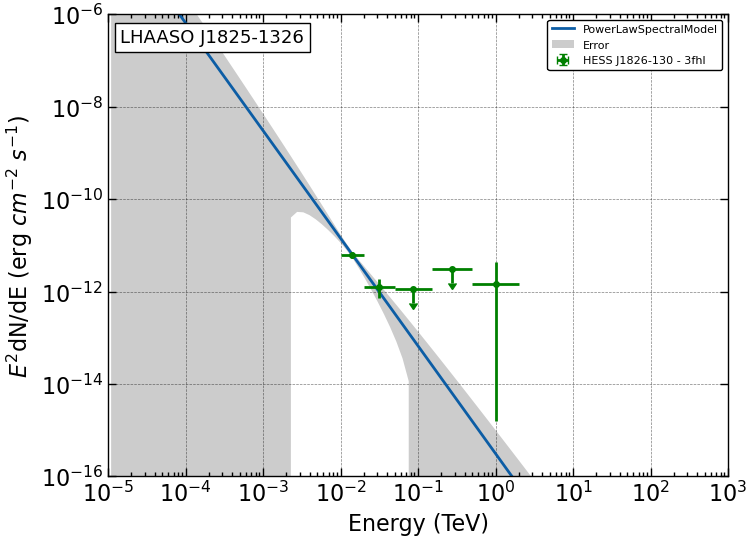

LHAASOJ1825-1326_HESSJ1826-130_3fhl_PowerLawSpectralModel:
  type      name     value         unit      ... max frozen is_norm link
-------- --------- ---------- -------------- ... --- ------ ------- ----
spectral     index 4.3306e+00                ... nan  False   False     
spectral amplitude 2.7005e-11 cm-2 GeV-1 s-1 ... nan  False    True     
spectral reference 1.3178e+01            GeV ... nan   True   False     


In [33]:
# to select a source object index: [0-6]
src_index = 1
colors_tag = colors_tags[src_index]
source_identification(src_index)
# LHAASO_name, src_name

# List of catalogs with flux points table of the source
# print(df_fp['catalog'][src_index])

k_range = range(len(ds_fp[src_index]))
for k in k_range: 
            
    # to select a catalog:
    cat_index = k
    catalog_tag = df_fp["catalog"][src_index][cat_index]
    catalog = CATALOG_REGISTRY.get_cls(catalog_tag)()
    # print(catalog)

    source  = catalog[src_name]
    # source.data

    flux_points = source.flux_points

    # Gammapy sky model object:
    sky_model = source.sky_model()

    # Gammapy spatial model object:
    spatial_model = source.spatial_model

    # Gammapy spectral model object:
    spectral_model = source.spectral_model()
    spectral_model_tag = spectral_model.tag[0]
    spectral_model_tag_short = spectral_model.tag[0]

    file_name = f'{LHAASO_txt}_{src_txt}_{catalog_tag}_{spectral_model_tag_short}.png'
    file_path = path_plot_spectrum / file_name 
    
    plot_SED()
    
    print(f'{LHAASO_txt}_{src_txt}_{catalog_tag}_{spectral_model_tag_short}:')
    
    print(spectral_model.parameters.to_table())
    

In [34]:
# Creating the directories to save the flux points figures
# dir_analysis = "analysis"
dir_flux_points_figures = "flux_points_figures"

path_flux_points_figures_analysis = mkdir_sub_directory(
#     dir_analysis, 
    dir_flux_points_figures
)

Directory 'flux_points_figures' created


In [35]:
def plotting_SED_flux_pointing(datasets = None, spectral_model = None, sed_type = "e2dnde", yaxis_units="TeV cm-2 s-1", energy_bounds= [1e-5, 1e2] * u.TeV, ylim = [1e-13, 1e-9]):
    '''Returns a spectral energy distribution
    
    >>> plotting_SED_flux_pointing(spec_model, yaxis_units, sed_type, reference)
    '''
    
    ax = plt.subplot()
    ax.yaxis.set_units(u.Unit(yaxis_units))
    ax.xaxis.set_units(u.Unit("TeV"))

    #label = f"{sky_model}"
    
    kwargs = {
        "ax": ax, 
        "sed_type": sed_type
    }    
    
    
#     plot_kwargs = {
#     "energy_bounds": [0.1, 30] * u.TeV,
#     "sed_type": "e2dnde",
#     "yunits": u.Unit("erg cm-2 s-1"),
#     "ax": ax,
# }
    
#     ax.loglog(J1825['e_ref'],J1825['e2dnde'], 'o', color='red', lw=2, ms=4)
#     ax.errorbar(J1825['e_ref'],J1825['e2dnde'], yerr=[J1825['e2dnde_errn'], J1825['e2dnde_errp']],fmt='.', color='red', label=LHAASO_name)

    
    for d in datasets:
        d.data.plot(label=d.name, **kwargs)

    try:   

        kwargs_fit = {"label":sky_model.name}
        spectral_model.plot(energy_bounds=energy_bounds, color="k", **kwargs, **kwargs_fit)
        spectral_model.plot_error(energy_bounds=energy_bounds, **kwargs)
        
        if combined_ds == False:
            file = path_flux_points_figures_analysis / f'{LHAASO_txt}_{src_txt}_{sky_model.name}.png'
        else:
            file = path_flux_points_figures_analysis / f'{LHAASO_txt}_{sky_model.name}.png'
            
    except:
        
        if combined_ds == False:
            file = path_flux_points_figures_analysis / f'{LHAASO_txt}_{src_txt}.png'
        else:
            file = path_flux_points_figures_analysis / f'{LHAASO_txt}.png'
    

    
    ax.set_ylim(ylim)
    ax.set_xlim(energy_bounds)
    ax.legend(facecolor='white', edgecolor='black',  loc='upper right', prop={'size': 8})
    
    ax.text(0.02, .94, LHAASO_name, transform=ax.transAxes, bbox=dict(facecolor='white', edgecolor='black'), size=15)

        
#     plt.title(f"{LHAASO_name}: {src_name}")
    
    plt.xlabel("Energy (TeV)")   
    plt.ylabel(r"$E^{2}$dN/dE (erg $cm^{-2}$ $s^{-1}$)")
    
    plt.savefig(file, bbox_inches='tight')
    plt.show()
    
    return 

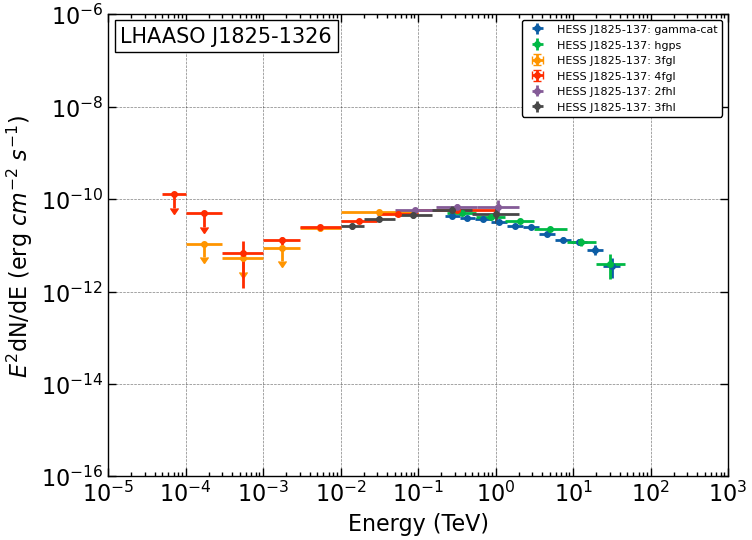

In [36]:
import scienceplots
plt.style.use(['science', 'notebook', 'grid'])

# to select a source object index: [0-6]
src_index = 0

source_identification(src_index)

ds_src = ds_fp[src_index]

datasets = Datasets(ds_src)

# energy_bounds = [1e-5, 1e2] * u.TeV
# ylim = [1e-16, 1e-7]

combined_ds = False
plotting_SED_flux_pointing(
    datasets = datasets,
    sed_type = sed_type, 
    yaxis_units="erg cm-2 s-1", 
    energy_bounds=energy_bounds, 
    ylim=ylim)

## 

In [37]:
import scienceplots
plt.style.use(['science', 'notebook', 'grid'])

# to select a source object index: [0-6]
src_index = 6

source_identification(src_index)

LHAASO_name

'LHAASO J2226+6057'

In [38]:
ds_src_combined = list(ds_fp[src_index])

In [39]:
ds_src_combined

In [40]:
for item in ds_fp[5]:
    ds_src_combined.append(item)

In [41]:
ds_src_combined

In [42]:
ds_src_combined_3 = list(ds_src_combined)

In [43]:
ds_src_combined_2 = list(ds_src_combined)

In [44]:
ds_src_combined_1 = list(ds_src_combined)

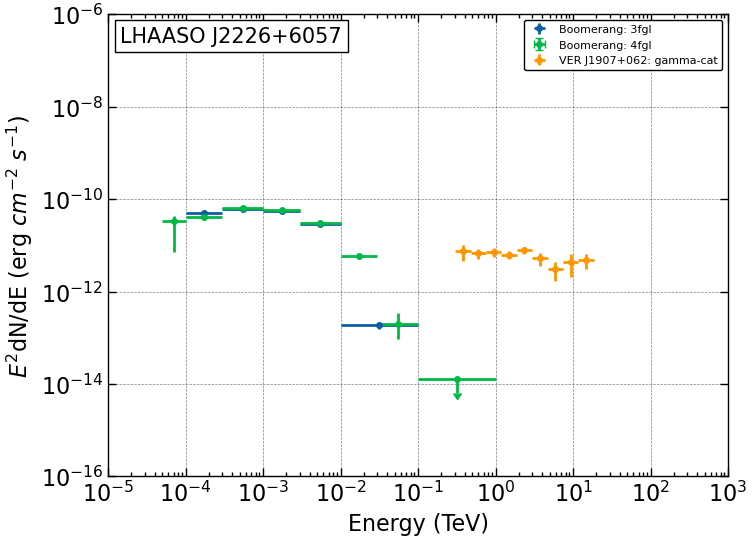

In [45]:
datasets_combined = Datasets(ds_src_combined_3)

# energy_bounds = [1e-5, 1e2] * u.TeV
ylim = [1e-16, 1e-6]

combined_ds = True
plotting_SED_flux_pointing(
    datasets = datasets_combined,
    sed_type = sed_type, 
    yaxis_units="erg cm-2 s-1", 
    energy_bounds=energy_bounds, 
    ylim=ylim)

## Data Reduction (DL3toDL4)

In [46]:
import numpy as np
# from astropy import units as u
from astropy.table import Table
from gammapy.estimators import FluxPoints
from gammapy.utils.scripts import make_path

# format_csv = ".csv"
format_fits = ".fits"

sed_type="e2dnde"
# sed_type="dnde"

ds_fp_cut = []
def flux_points_cut_energy(df_fp = None, ds_fp = None, e_ref_min=None):
    '''To write Docstring!!!!'''
    
    source_range = range(len(df_fp))
    for src_index in source_range:
        src_ds = []
        
        source_identification(src_index)
        
        k_range = range(len(ds_fp[src_index]))
        for k in k_range: 
            
            catalog_tag = df_fp["catalog"][src_index][k]

            ds_name = f"{src_name}: {catalog_tag}"
            flux_points = ds_fp[src_index][k].data

            mask_energy = np.zeros(len(flux_points.to_table()), dtype=bool)

            for m, e_ref in enumerate(flux_points.energy_ref):
                if e_ref > e_ref_min:
                    mask_energy[m] = True
            print(ds_name, src_txt)  
            
            try:
                flux_points_mask = flux_points.to_table()[mask_energy]
                flux_points_energy = FluxPoints.from_table(flux_points_mask)

                ds = FluxPointsDataset(
                                    data=flux_points_energy, 
                                    name=ds_name
                                )

                table = ds.data.to_table(
                                    sed_type = sed_type, 
                                    formatted = True
                                )
                src_ds.append(ds)

                file_name = f'{LHAASO_txt}_{src_txt}_{catalog_tag}_e_ref_min_{e_ref_min_name}{format_fits}'
                path_os = os.path.abspath(
                    os.path.join(
                        f"{path_flux_points_tables_analysis}/{file_name}"
                    )
                )

                if path_os not in sys.path:
                    sys.path.append(path_os)

                table.write(f"{path_os}",format='fits', overwrite=True)

            except:
                print(f"{src_name} out")    
            
        ds_fp_cut.append(src_ds)
    return ds_fp_cut

### Cutting energy

In [47]:
# Defining the minimum value of the reference energy  
e_ref_min = 100 * u.Unit("GeV")
e_ref_min_name = str(e_ref_min).replace(" ", "")

In [48]:
# Creating the directories to save the tables
dir_analysis = "analysis"
dir_flux_points_tables = f"flux_points_table_e_ref_min_{e_ref_min_name}"

path_catalogs_data, path_flux_points_tables_analysis = mkdir_sub_directory(
    dir_analysis, 
    dir_flux_points_tables
)

Directory 'analysis/flux_points_table_e_ref_min_100.0GeV' created


In [49]:
ds_fp_cut = flux_points_cut_energy(df_fp = df_fp, ds_fp = ds_fp, e_ref_min=e_ref_min)

No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.


HESS J1825-137: gamma-cat HESSJ1825-137
HESS J1825-137: hgps HESSJ1825-137
HESS J1825-137: 3fgl HESSJ1825-137
HESS J1825-137 out
HESS J1825-137: 4fgl HESSJ1825-137


No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.


HESS J1825-137: 2fhl HESSJ1825-137
HESS J1825-137: 3fhl HESSJ1825-137
HESS J1826-130: gamma-cat HESSJ1826-130
HESS J1826-130: hgps HESSJ1826-130


No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.


HESS J1826-130: 4fgl HESSJ1826-130
HESS J1826-130: 3fhl HESSJ1826-130
MGRO J1908+06: gamma-cat MGROJ1908+06
MGRO J1908+06: 3fgl MGROJ1908+06
MGRO J1908+06 out
MGRO J1908+06: 4fgl MGROJ1908+06


No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.


HESS J1908+063: gamma-cat HESSJ1908+063
HESS J1908+063: hgps HESSJ1908+063
ARGO J1907+0627: gamma-cat ARGOJ1907+0627
VER J1907+062: gamma-cat VERJ1907+062
Boomerang: 3fgl Boomerang
Boomerang out
Boomerang: 4fgl Boomerang


No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.


In [50]:
# Creating the directories to save the tables
dir_analysis = "analysis"
dir_flux_points_figures = f"flux_points_figures_e_ref_min_{e_ref_min_name}"

path_analysis, path_flux_points_figures_analysis = mkdir_sub_directory(
    dir_analysis, 
    dir_flux_points_figures
)

Directory 'analysis/flux_points_figures_e_ref_min_100.0GeV' created


In [51]:
# to select a source object index: [0-6]
src_index = 6

source_identification(src_index)

LHAASO_name

'LHAASO J2226+6057'

In [52]:
ds_src_combined_cut = list(ds_fp_cut[src_index])

In [53]:
ds_src_combined_cut

In [54]:
for item in ds_fp_cut[5]:
    ds_src_combined_cut.append(item)

In [55]:
ds_src_combined_cut

In [56]:
ds_src_combined_cut_3 = list(ds_src_combined_cut)

In [57]:
ds_src_combined_cut_2 = list(ds_src_combined_cut)

In [58]:
ds_src_combined_cut_1 = list(ds_src_combined_cut)

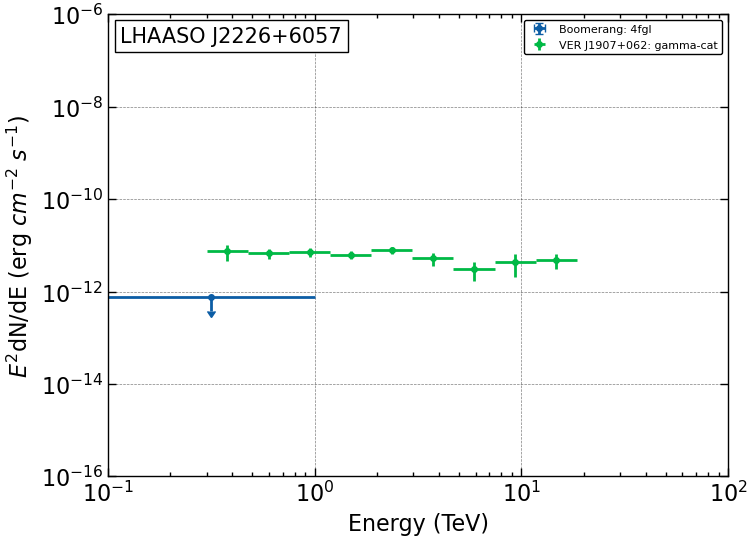

In [59]:
datasets_combined = Datasets(ds_src_combined_cut_3)

energy_bounds = [1e-1, 1e2] * u.TeV
# ylim = [1e-16, 1e-6]

combined_ds = True
plotting_SED_flux_pointing(
    datasets = datasets_combined,
    sed_type = sed_type, 
    yaxis_units="erg cm-2 s-1", 
    energy_bounds=energy_bounds, 
    ylim=ylim)

### SED cutting energy

In [60]:
# Creating the directories to save the tables
dir_analysis = "analysis"
dir_flux_points_figures = f"SED_figures_e_ref_min_{e_ref_min_name}"

path_analysis, path_flux_points_figures_analysis = mkdir_sub_directory(
    dir_analysis, 
    dir_flux_points_figures
)

Directory 'analysis/SED_figures_e_ref_min_100.0GeV' created


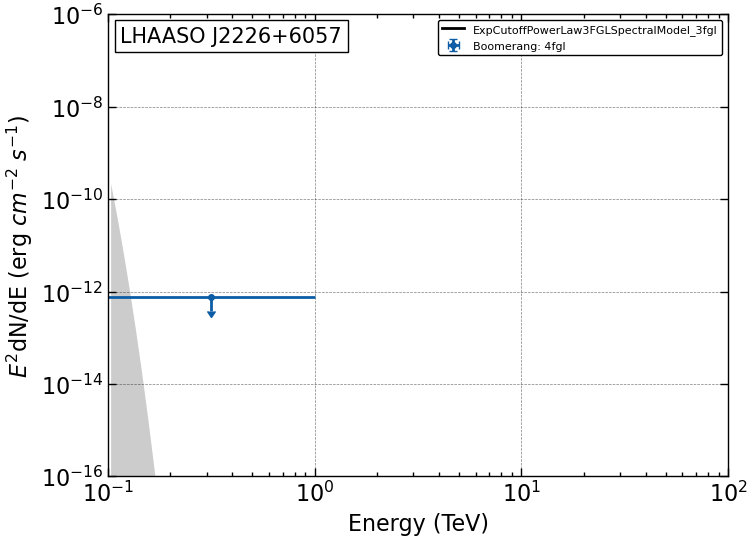

In [61]:
# to select a source object index: [0-6]
src_index = 6
cat_index = 0
# src = source_cat[src_index][0]
source_identification(src_index)

catalog_tag = df_fp["catalog"][src_index][cat_index]

ds_src = ds_fp_cut[src_index]
# ds_src = ds_src_combined_cut_1

spectral_model = source_cat[src_index][cat_index].spectral_model()
# spectral_model = PowerLawSpectralModel(
#     index=2,
#     amplitude="1e-10 TeV-1 cm-2 s-1",
#     reference=1 * u.TeV,
# )

name = f"{spectral_model.tag[0]}_{df_fp['catalog'][src_index][cat_index]}"
    
sky_model = SkyModel(spectral_model=spectral_model, name=name)

datasets = Datasets(ds_src)
datasets.models = sky_model

fitter = Fit()

result_fit = fitter.run(datasets=datasets)

plotting_SED_flux_pointing(
    datasets = datasets,
    spectral_model=spectral_model, 
    sed_type = "e2dnde", 
    yaxis_units="erg cm-2 s-1", 
    energy_bounds=energy_bounds, 
    ylim=ylim
)

In [62]:
src_name

'Boomerang'

In [67]:
J1825_flux_points = FluxPoints.from_table(table = J1825)

In [68]:
J1825_ds = FluxPointsDataset(
    data = J1825_flux_points, 
    name = f"{LHAASO_name}"
)
ds_fp_cut[src_index].append(J1825_ds)



NameError: name 'J1825_flux_points' is not defined

In [ ]:
print(ds_fp_cut[src_index][3])

/home/gamma/anaconda3/envs/gammapy-1.0.1/lib/python3.9/site-packages/astropy/units/quantity.py:620: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/gamma/anaconda3/envs/gammapy-1.0.1/lib/python3.9/site-packages/gammapy/datasets/flux_points.py:288: RuntimeWarning: overflow encountered in square
  return ((data - model) / sigma.quantity[:, 0, 0]).to_value("") ** 2


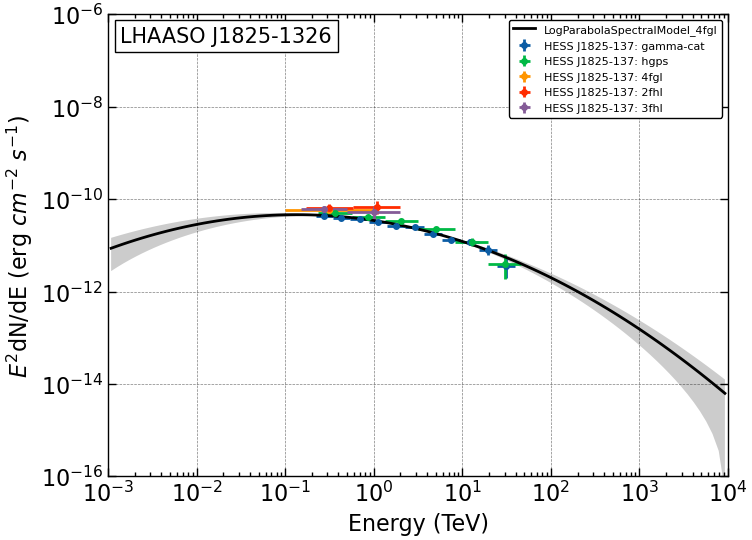

In [69]:
# to select a source object index: [0-6]
src_index = 0
cat_index = 3
# src = source_cat[src_index][0]
source_identification(src_index)

catalog_tag = df_fp["catalog"][src_index][cat_index]

ds_src = ds_fp_cut[src_index]
# ds_src = ds_src_combined_cut_3

# spectral_model = source_cat[src_index][cat_index].spectral_model()

# spectral_model = PowerLawSpectralModel(
#     index=2,
#     amplitude="1e-10 TeV-1 cm-2 s-1",
#     reference=1 * u.TeV,
# )


spectral_model = LogParabolaSpectralModel(
    alpha=0.92,
    amplitude="1e-12 cm-2 s-1 erg-1",
    reference=1 * u.TeV,
    beta=1.19,
)


name = f"{spectral_model.tag[0]}_{df_fp['catalog'][src_index][cat_index]}"
    
sky_model = SkyModel(spectral_model=spectral_model, name=name)

datasets = Datasets(ds_src)
datasets.models = sky_model

fitter = Fit()

result_fit = fitter.run(datasets=datasets)

energy_bounds = [1e-3, 1e4] * u.TeV
# ylim = [1e-16, 1e-6]

plotting_SED_flux_pointing(
    datasets = datasets,
    spectral_model=spectral_model, 
    sed_type = "e2dnde", 
    yaxis_units="erg cm-2 s-1", 
    energy_bounds=energy_bounds, 
    ylim=ylim
)

In [70]:
print(result_fit.models.parameters.to_table())

  type      name     value         unit      ... max frozen is_norm link
-------- --------- ---------- -------------- ... --- ------ ------- ----
spectral amplitude 1.3478e-11 cm-2 erg-1 s-1 ... nan  False    True     
spectral reference 1.0000e+00            TeV ... nan   True   False     
spectral     alpha 2.2877e+00                ... nan  False   False     
spectral      beta 7.1840e-02                ... nan  False   False     


In [71]:
spectral_model.reference

Parameter(name='reference', value=1.0, factor=1.0, scale=1.0, unit=Unit("TeV"), min=nan, max=nan, frozen=True, id=0x7ff9c83ee0a0)

In [72]:
# to select a source object index: [0-6]
src_index = 0
source_identification(src_index)
LHAASO_name, src_name

('LHAASO J1825-1326', 'HESS J1825-137')

In [73]:
# List of catalogs with flux points table of the source
df_fp['catalog'][src_index]

['gamma-cat', 'hgps', '3fgl', '4fgl', '2fhl', '3fhl']

In [74]:
# to select a catalog:
cat_index = 4
catalog_tag = df_fp["catalog"][src_index][cat_index]
catalog = CATALOG_REGISTRY.get_cls(catalog_tag)()
# print(catalog)

In [75]:
source  = catalog[src_name]
# source.data

In [76]:
flux_points = source.flux_points
flux_points.to_table(sed_type="e2dnde", formatted=True)

e_ref,e_min,e_max,e2dnde,e2dnde_errp,e2dnde_errn,e2dnde_ul,is_ul
GeV,GeV,GeV,GeV / (cm2 s),GeV / (cm2 s),GeV / (cm2 s),GeV / (cm2 s),
float64,float64,float64,float64,float64,float64,float64,bool
92.466,50.000,171.000,3.629e-08,4.095e-09,3.923e-09,nan,False
316.283,171.000,585.000,4.156e-08,7.342e-09,6.711e-09,nan,False
1081.665,585.000,2000.000,4.329e-08,1.586e-08,1.346e-08,nan,False


In [77]:
# Gammapy sky model object:
sky_model = source.sky_model()

# Gammapy spatial model object:
spatial_model = source.spatial_model

# Gammapy spectral model object:
spectral_model = source.spectral_model()
spectral_model_tag = spectral_model.tag[0]
spectral_model_tag_short = spectral_model.tag[0]

In [78]:
# energy_bounds = [1e-5, 1e3] * u.TeV
# ylim = [1e-20, 1e-7]

In [79]:
file_name = f'{LHAASO_txt}_{src_txt}_{spectral_model_tag_short}.png'
file_path = path_plot_spectrum / file_name

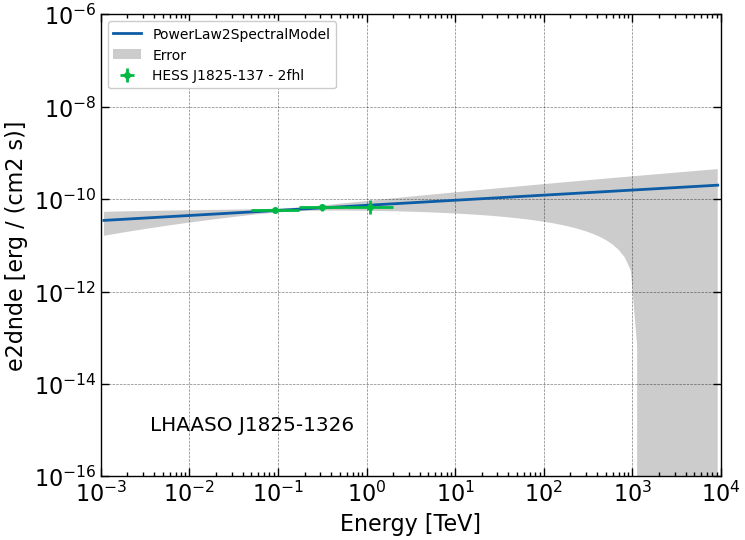

In [80]:
plt.style.use(['science', 'notebook', 'grid'])

plt.figure()

ax = spectral_model.plot(energy_bounds, sed_type="e2dnde")
ax = spectral_model.plot_error(energy_bounds, sed_type="e2dnde")
flux_points.plot(ax=ax, sed_type="e2dnde")
ax.text(0.08, 0.1, LHAASO_name, transform=ax.transAxes, fontsize = "x-large")

ax.set_ylim(ylim)
ax.set_xlim(energy_bounds)

# plt.title(f"{LHAASO_name}: {src_name}")
plt.legend([spectral_model_tag, "Error", f"{src_name} - {catalog_tag}"], loc='upper left', prop={'size': 10})
plt.savefig(file_path, bbox_inches='tight')
plt.show()

In [81]:
file_name

'LHAASOJ1825-1326_HESSJ1825-137_PowerLaw2SpectralModel.png'

No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.


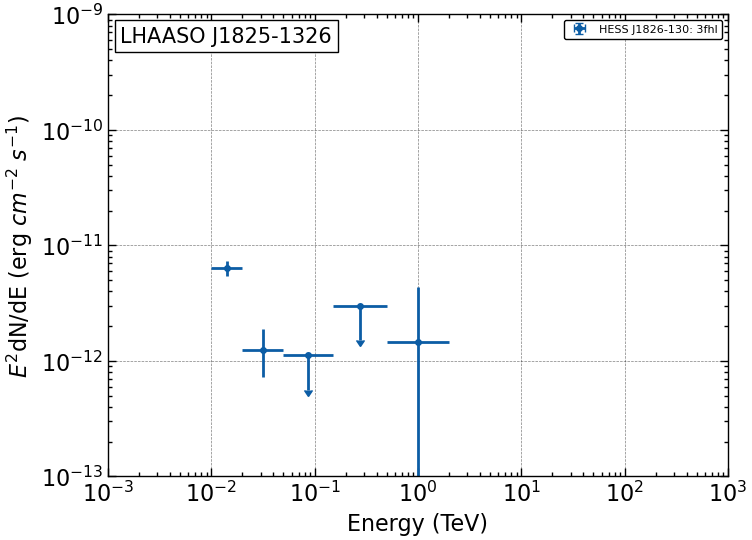

In [82]:
src_index = 1
source_identification(src_index)
catalog_tag = df_fp["catalog"][src_index][3]

file_name = f'{LHAASO_txt}_{src_txt}_{catalog_tag}{format_fits}'
file_path = make_path(f"{path_flux_points_tables}/{file_name}")
flux_points = FluxPoints.read(file_path, sed_type=sed_type)
ds = FluxPointsDataset(
    data = flux_points, 
    name = f"{src_name}: {catalog_tag}"
)
datasets = Datasets(ds)


# opts = dict(sed_type="e2dnde", yunits=u.Unit("TeV cm-2 s-1"))
energy_bounds = [1e-3, 1e3] * u.TeV
ylim = [1e-13, 1e-9]
plotting_SED_flux_pointing(
    datasets = datasets,
#     spectral_model=spectral_model, 
    sed_type = "e2dnde", 
    yaxis_units="erg cm-2 s-1", 
    energy_bounds=energy_bounds, 
    ylim=ylim)


No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.


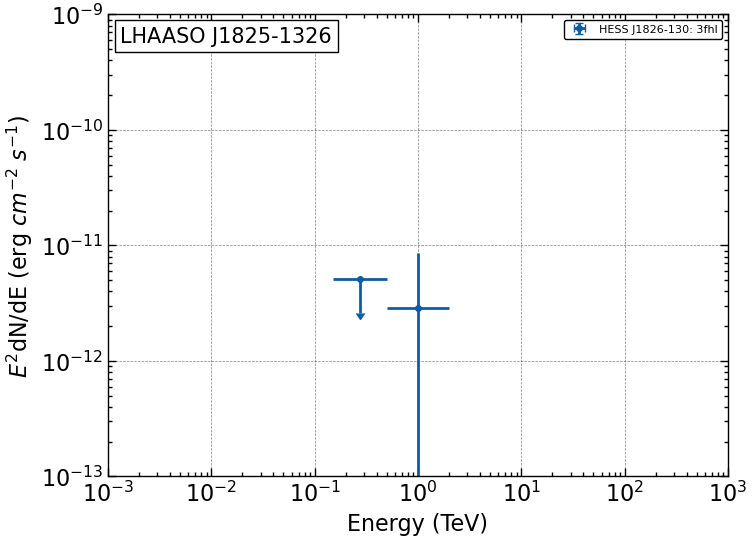

In [83]:
source_identification(src_index)
catalog_tag = df_fp["catalog"][src_index][3]

file_name = f'{LHAASO_txt}_{src_txt}_{catalog_tag}_e_ref_min_{e_ref_min_name}{format_fits}'
file_path = make_path(f"{path_flux_points_tables_analysis}/{file_name}")
flux_points = FluxPoints.read(file_path, sed_type=sed_type)
ds = FluxPointsDataset(
    data = flux_points, 
    name = f"{src_name}: {catalog_tag}"
)
datasets = Datasets(ds)


# opts = dict(sed_type="e2dnde", yunits=u.Unit("TeV cm-2 s-1"))
energy_bounds = [1e-3, 1e3] * u.TeV
ylim = [1e-13, 1e-9]
plotting_SED_flux_pointing(
    datasets = datasets,
#     spectral_model=spectral_model, 
    sed_type = "e2dnde", 
    yaxis_units="erg cm-2 s-1", 
    energy_bounds=energy_bounds, 
    ylim=ylim)


## Table LHAASO

In [84]:
from pathlib import Path

In [85]:
directory_path = '../publishNature'
format_dat = '.dat'
file_name = "J1825_KM2A_201209"
file_abs_name = f'{file_name}{format_dat}'

file_path = Path(f'{directory_path}/{file_abs_name}') 
J1825 = Table.read(file_path,format='ascii', delimiter=' ', comment='#')
J1825

col1,col2,col3,col4,col5,col6
float64,float64,float64,float64,float64,float64
31600000000000.0,1.664e-11,5.2640001e-12,5.2640001e-12,6500000000000.0,8190000000000.0
50100000000000.0,6.9440001e-12,1.4784e-12,1.4784e-12,10300000000000.0,13000000000000.0
79400000000000.0,5.5200001e-12,6.5440001e-13,6.5440001e-13,16300000000000.0,20600000000000.0
126000000000000.0,3.8080001e-12,5.6160001e-13,5.6160001e-13,25900000000000.0,32600000000000.0
200000000000000.0,9.6000001e-13,3.9040001e-13,3.296e-13,41000000000000.0,51700000000000.0
316000000000000.0,3.7120001e-13,2.992e-13,2.384e-13,65000000000000.0,81900000000000.0
501000000000000.0,1.936e-13,3.5520001e-13,1.2416e-13,103000000000000.0,130000000000000.0


In [86]:
# Table.read.list_formats()

In [87]:
J1825

col1,col2,col3,col4,col5,col6
float64,float64,float64,float64,float64,float64
31600000000000.0,1.664e-11,5.2640001e-12,5.2640001e-12,6500000000000.0,8190000000000.0
50100000000000.0,6.9440001e-12,1.4784e-12,1.4784e-12,10300000000000.0,13000000000000.0
79400000000000.0,5.5200001e-12,6.5440001e-13,6.5440001e-13,16300000000000.0,20600000000000.0
126000000000000.0,3.8080001e-12,5.6160001e-13,5.6160001e-13,25900000000000.0,32600000000000.0
200000000000000.0,9.6000001e-13,3.9040001e-13,3.296e-13,41000000000000.0,51700000000000.0
316000000000000.0,3.7120001e-13,2.992e-13,2.384e-13,65000000000000.0,81900000000000.0
501000000000000.0,1.936e-13,3.5520001e-13,1.2416e-13,103000000000000.0,130000000000000.0


In [88]:
from astropy.table import QTable
import astropy.units as u

J1825['col1'] = J1825['col1']/1e12
J1825.rename_column('col1', 'e_ref')
J1825['e_ref'].unit = u.TeV

J1825['col5'] = J1825['col5']/1e12
J1825.rename_column('col5', 'e_min')
J1825['e_min'].unit = u.TeV

J1825['col6'] = J1825['col6']/1e12
J1825.rename_column('col6', 'e_max')
J1825['e_max'].unit = u.TeV



J1825.rename_column('col2', 'e2dnde')
J1825['e2dnde'].unit = u.Unit("erg cm-2 s-1")

J1825.rename_column('col3', 'e2dnde_errp')
J1825['e2dnde_errp'].unit = u.Unit("erg cm-2 s-1")

J1825.rename_column('col4', 'e2dnde_errn')
J1825['e2dnde_errn'].unit = u.Unit("erg cm-2 s-1")

J1825.meta["SED_TYPE"] = "e2dnde"
J1825.meta["name"] = "J1825"





# # Writes the flux points table in the csv format
# file_abs_name = f'{file_name}{format_fits}'
# path_os = os.path.abspath(
#     os.path.join(
#         f"{directory_path}/{file_abs_name}"
#     )
# )

# if path_os not in sys.path:
#     sys.path.append(path_os)

# J1825.write(
#     f"{path_os}",
#     format = 'fits', 
#     overwrite = True
# )   

# # Writes the flux points table in the csv format
# file_abs_name = f'{file_name}{format_csv}'
# path_os = os.path.abspath(
#     os.path.join(
#         f"{directory_path}/{file_abs_name}"
#     )
# )

# if path_os not in sys.path:
#     sys.path.append(path_os)

# J1825.write(
#     f"{path_os}",
#     format = 'ascii.ecsv', 
#     overwrite = True
# )  

<Axes: xlabel='Energy [TeV]', ylabel='dnde [1 / (cm2 s TeV)]'>

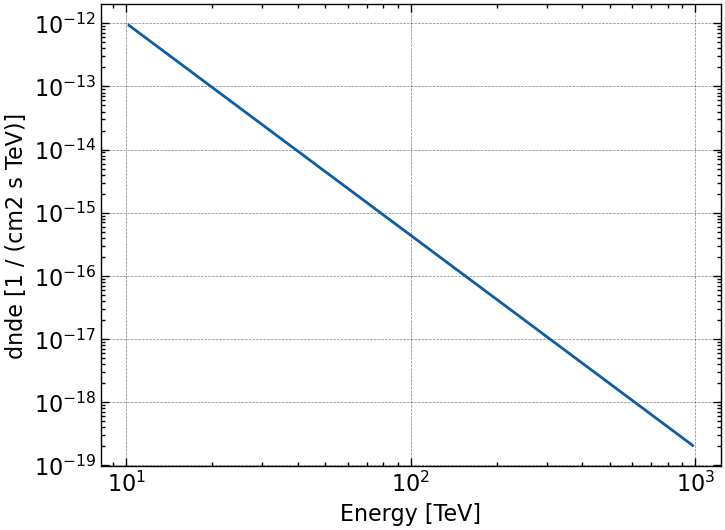

In [89]:
energy_bounds = [10, 1000] * u.TeV
model = PowerLawSpectralModel(
    index=3.36,
    ampliude="1.5e-12 TeV-1 cm-2 s-1",
    reference=10 * u.TeV,
)
{}
model.plot(energy_bounds)

In [90]:
J1825['e_ref'],J1825['e2dnde']

(<Column name='e_ref' dtype='float64' unit='TeV' length=7>
  31.6
  50.1
  79.4
 126.0
 200.0
 316.0
 501.0,
 <Column name='e2dnde' dtype='float64' unit='erg / (cm2 s)' length=7>
     1.664e-11
 6.9440001e-12
 5.5200001e-12
 3.8080001e-12
 9.6000001e-13
 3.7120001e-13
     1.936e-13)

In [91]:
def power_law(x,index=2, amplitude="1e-12 cm-2 s-1 erg-1", reference="1 TeV"):  
    return amplitude*(x/reference)**(-index)

In [92]:
lp = LogParabolaSpectralModel(
    alpha=1.56,
    amplitude="1e-11 cm-2 s-1 erg-1",
    reference=1 * u.TeV,
    beta=0.88,
)

In [93]:
from scipy.optimize import curve_fit
curve_fit(power_law, J1825['e_ref'], J1825['e2dnde'])

/tmp/ipykernel_1323478/1393154617.py:2: RuntimeWarning: invalid value encountered in power
  return amplitude*(x/reference)**(-index)


(array([1.35671632e+00, 4.73423693e-08, 8.79207103e-02]),
 array([[ 1.13782341e-01, -8.89920142e-01,  1.21959627e+06],
        [-8.89920142e-01,  1.00255113e+01, -1.37395206e+07],
        [ 1.21959627e+06, -1.37395206e+07,  1.88294063e+13]]))

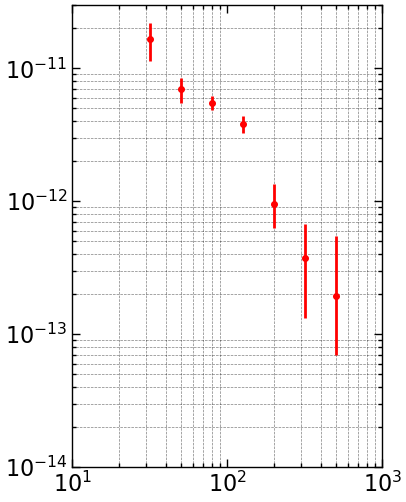

In [94]:
pwl = PowerLawSpectralModel(
    index=2, amplitude="1e-12 cm-2 s-1 erg-1", reference="1 TeV"
)


plt.figure(figsize=(4,6))
plt.loglog(J1825['e_ref'],J1825['e2dnde'], 'o', color='red', lw=2, ms=4)
plt.errorbar(J1825['e_ref'],J1825['e2dnde'], yerr=[J1825['e2dnde_errn'], J1825['e2dnde_errp']],fmt='.', color='red')
# lp.plot(energy_bounds=[10, 1000]* u.TeV, color="k")
# # lp.plot_error(energy_bounds=[10, 1000]* u.TeV)

# # pwl.plot(energy_bounds=[10, 1000]* u.TeV, color="k")
# # pwl.plot_error(energy_bounds=[10, 1000]* u.TeV)
# model = PowerLawSpectralModel(
#     index=3.36,
#     amplitude="1.5e-11 erg-1 cm-2 s-1",
#     reference=1* u.TeV,
# )
# model.plot(energy_bounds, sed_type=sed_type)


plt.xlim(10, 1000)
plt.ylim(1e-14, 3e-11)
plt.grid(which="both")

<ErrorbarContainer object of 3 artists>

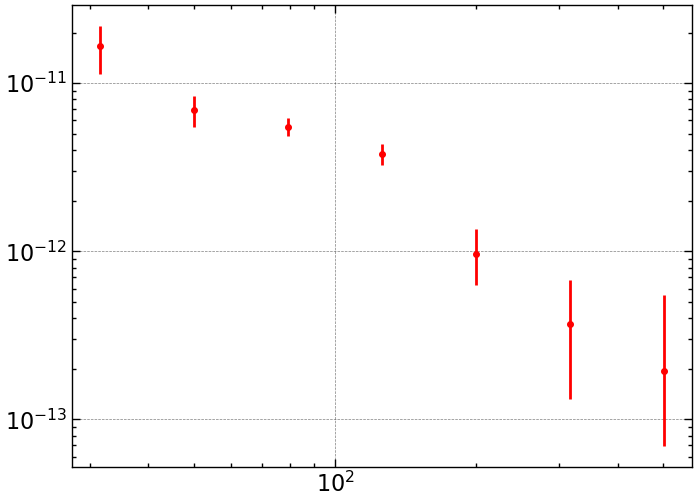

In [95]:
ax = plt.subplot()
ax.loglog(J1825['e_ref'],J1825['e2dnde'], 'o', color='red', lw=2, ms=4)
ax.errorbar(J1825['e_ref'],J1825['e2dnde'], yerr=[J1825['e2dnde_errn'], J1825['e2dnde_errp']],fmt='.', color='red')



<ErrorbarContainer object of 3 artists>

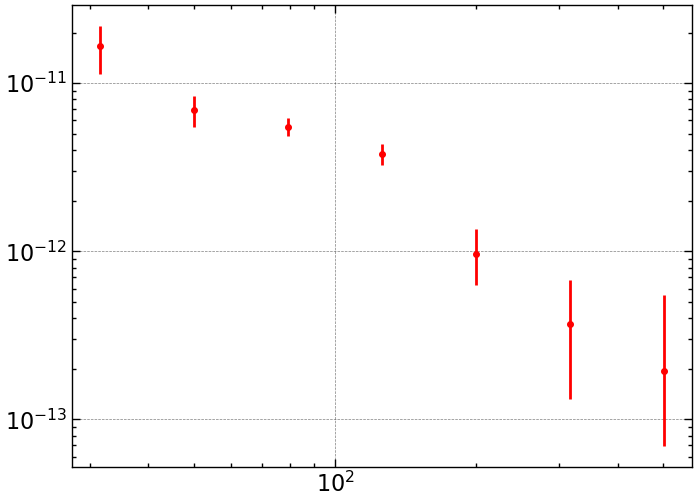

In [96]:
plt.loglog(J1825['e_ref'],J1825['e2dnde'], 'o', color='red', lw=2, ms=4)
plt.errorbar(J1825['e_ref'],J1825['e2dnde'], yerr=[J1825['e2dnde_errn'], J1825['e2dnde_errp']],fmt='.', color='red')


In [97]:
# file_name = "J1825_KM2A_201209"
# file_abs_name = f'{file_name}{format_fits}'

# file_path = Path(f'{directory_path}/{file_abs_name}') 
# J1825_t = Table.read(file_path,format='fits')
# J1825_t

In [98]:
J1825.meta

OrderedDict([('SED_TYPE', 'e2dnde'), ('name', 'J1825')])

In [99]:
FluxPoints.from_table(table = J1825, sed_type='e2dnde')

No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.


In [100]:
file_path = Path(f'../publishNature/J1908_KM2A_201209.dat') 
J1908 = Table.read(file_path ,format='ascii', delimiter=' ', comment='#')
J1908

col1,col2,col3,col4,col5,col6
float64,float64,float64,float64,float64,float64
12600000000000.0,9.2640001e-12,1.2976e-12,1.2976e-12,2590000000000.0,3260000000000.0
20000000000000.0,1.024e-11,8.1280001e-13,8.1280001e-13,4100000000000.0,5170000000000.0
31600000000000.0,6.2720001e-12,4.7840001e-13,4.7840001e-13,6500000000000.0,8190000000000.0
50100000000000.0,4.6560001e-12,3.4880001e-13,3.4880001e-13,10300000000000.0,13000000000000.0
79400000000000.0,2.8e-12,2.688e-13,2.688e-13,16300000000000.0,20600000000000.0
126000000000000.0,1.3584e-12,2.08e-13,2.08e-13,25900000000000.0,32600000000000.0
200000000000000.0,1.184e-12,2.208e-13,2.208e-13,41000000000000.0,51700000000000.0
316000000000000.0,4.4640001e-13,2.192e-13,1.5344e-13,65000000000000.0,81900000000000.0
501000000000000.0,2.192e-13,1.856e-13,1.4416e-13,103000000000000.0,130000000000000.0


In [101]:
file_path = Path(f'../publishNature/J2228_KM2A_201209.dat') 
J2228 = Table.read(file_path,format='ascii', delimiter=' ', comment='#')
J2228

col1,col2,col3,col4,col5,col6
float64,float64,float64,float64,float64,float64
20000000000000.0,4.0320001e-12,8.0000001e-13,8.0000001e-13,4100000000000.0,5170000000000.0
31600000000000.0,3.264e-12,4.6720001e-13,4.6720001e-13,6500000000000.0,8190000000000.0
50100000000000.0,2.992e-12,3.04e-13,3.04e-13,10300000000000.0,13000000000000.0
79400000000000.0,1.4128e-12,2.016e-13,2.016e-13,16300000000000.0,20600000000000.0
126000000000000.0,1.1968e-12,1.856e-13,1.856e-13,25900000000000.0,32600000000000.0
200000000000000.0,3.4240001e-13,1.3824e-13,1.152e-13,41000000000000.0,51700000000000.0
316000000000000.0,1.2816e-13,1.1968e-13,8.7040001e-14,65000000000000.0,81900000000000.0
501000000000000.0,6.9440001e-14,1.3456e-13,4.7040001e-14,103000000000000.0,130000000000000.0


In [102]:
J1825

e_ref,e2dnde,e2dnde_errp,e2dnde_errn,e_min,e_max
TeV,erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),TeV,TeV
float64,float64,float64,float64,float64,float64
31.6,1.664e-11,5.2640001e-12,5.2640001e-12,6.5,8.19
50.1,6.9440001e-12,1.4784e-12,1.4784e-12,10.3,13.0
79.4,5.5200001e-12,6.5440001e-13,6.5440001e-13,16.3,20.6
126.0,3.8080001e-12,5.6160001e-13,5.6160001e-13,25.9,32.6
200.0,9.6000001e-13,3.9040001e-13,3.296e-13,41.0,51.7
316.0,3.7120001e-13,2.992e-13,2.384e-13,65.0,81.9
501.0,1.936e-13,3.5520001e-13,1.2416e-13,103.0,130.0


In [103]:
flux_points_ = FluxPoints.from_table(J1825, sed_type="e2dnde")

No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.


<Axes: xlabel='Energy [TeV]', ylabel='e2dnde [erg / (cm2 s)]'>

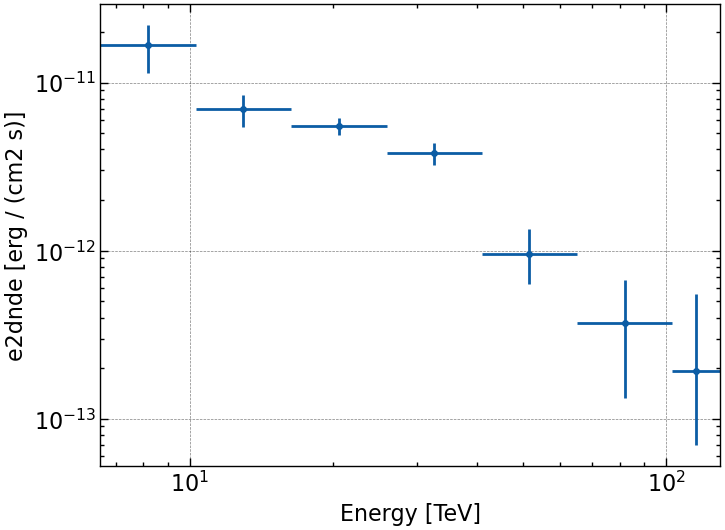

In [104]:
flux_points_.plot()

In [105]:
e_ref = J1825['col1']/1e12
e_min = J1825['col5']/1e12
e_max = J1825['col6']/1e12

e2dnde = J1825['col2']
e2dnde_errp = J1825['col3']
e2dnde_errn = J1825['col4']

J1825_table = Table(
    [e_ref, e2dnde, e2dnde_errp, e2dnde_errn, e_min, e_max],
    names=('e_ref', 'e2dnde', 'e2dnde_errp', 'e2dnde_errn', 'e_min', 'e_max'),
    meta={'name': 'J1825','SED_TYPE': 'e2dnde' }
)

J1825_table['e_ref'].unit = u.TeV
J1825_table['e_min'].unit = u.TeV
J1825_table['e_max'].unit = u.TeV

J1825_table['e2dnde'].unit = u.Unit("erg cm-2 s-1")
J1825_table['e2dnde_errp'].unit = u.Unit("erg cm-2 s-1")
J1825_table['e2dnde_errn'].unit = u.Unit("erg cm-2 s-1")

KeyError: 'col1'

In [ ]:
J1825_table.meta

In [ ]:
flux_points2 = FluxPoints.from_table(J1825_table, sed_type="e2dnde")
flux_points2.to_table()

In [ ]:
e_ref = J1908['col1']
e2dnde = J1908['col2']
e2dnde_errp = J1908['col2']
e2dnde_errn = J1908['col3']
J1908_table = QTable([e_ref, e2dnde, e2dnde_errp, e2dnde_errn],
           names=('e_ref', 'e2dnde', 'e2dnde_errp', 'e2dnde_errn'),
           meta={'name': 'J1908'})

J1908_table['e_ref'] = J1908['col1']/1e12
J1908_table['e_ref'].unit = u.TeV
J1908_table['e2dnde'].unit = u.Unit("erg cm-2 s-1")
J1908_table['e2dnde_errp'].unit = u.Unit("erg cm-2 s-1")
J1908_table['e2dnde_errn'].unit = u.Unit("erg cm-2 s-1")

In [ ]:
J1908_table

In [ ]:
e_ref = J2228['col1']
e2dnde = J2228['col2']
e2dnde_errp = J2228['col3']
e2dnde_errn = J2228['col4']
J2228_table = QTable([e_ref, e2dnde, e2dnde_errp, e2dnde_errn],
           names=('e_ref', 'e2dnde', 'e2dnde_errp', 'e2dnde_errn'),
           meta={'name': 'J2228'})

J2228_table['e_ref'] = J2228['col1']/1e12
J2228_table['e_ref'].unit = u.TeV
J2228_table['e2dnde'].unit = u.Unit("erg cm-2 s-1")
J2228_table['e2dnde_errp'].unit = u.Unit("erg cm-2 s-1")
J2228_table['e2dnde_errn'].unit = u.Unit("erg cm-2 s-1")

In [ ]:
flux_points_ = FluxPoints.from_table(J1825_table)
flux_points_.to_table()

In [ ]:
flux_points_.plot()

In [ ]:
flux_points_.to_table()

In [ ]:
ds = FluxPointsDataset(
    data = flux_points_, 
    name = f"{src_name}: {catalog_tag}"
)
datasets = Datasets(ds)


# opts = dict(sed_type="e2dnde", yunits=u.Unit("TeV cm-2 s-1"))
energy_bounds = [10, 1e3] * u.TeV
ylim = [1e-14, 3e-11]
plotting_SED_flux_pointing(
    datasets = datasets,
#     spectral_model=spectral_model, 
    sed_type = "e2dnde", 
    yaxis_units="erg cm-2 s-1", 
    energy_bounds=energy_bounds, 
    ylim=ylim)


In [ ]:
# table.rename_column('col2', 'e_ref')  
# table["e_ref"].unit = u.eV
# table["e_ref"]

In [ ]:
flux_points_.plot()

#### Let's plot the spectrum

    TF1 *f=new TF1("f","[0]*pow(x/20.0,[1])*pow(x,2)",10,2000);
          f->SetParameters(1.5e-11,-2.4);

      TF1 *f2=new TF1("f2","[0]*pow(x/20.,[1]+[2]*log10(x/20.))*pow(x,2)");
          f2->SetParameters(2.e-14,-2.6,-0.2,1000);

In [ ]:
source  = catalog[src_name]
# Gammapy sky model object:
sky_model = source.sky_model()

# Gammapy spatial model object:
spatial_model = sky_model.spatial_model

# Gammapy spectral model object:
spectral_model = sky_model.spectral_model
spectral_model_tag = spectral_model.tag[0]

In [ ]:
source.data

In [ ]:
print(sky_model)

In [ ]:
print(spatial_model)

In [ ]:
print(spectral_model)

In [ ]:
ds_fp[src_index][cat_index]

In [ ]:
def plot_spectrum(data = None):
    plt.style.use(['science', 'notebook', 'grid'])
    fig, ax = plt.subplots(1, 1, figsize=(6,5))

    kwargs_model = {
        "color":"black",
        "ls":"--"
    }
    kwargs_fp = {
        "color":"blue", 
        "marker":"o"
    }

    data = data
    data.plot_spectrum(
        ax = ax,  
        kwargs_fp = kwargs_fp, 
        kwargs_model = kwargs_model
    )

    title = f"{LHAASO_name}: {src_name}\n{catalog_tag}: {spectral_model_tag}"

    ax.text(
        0.1, 0.1, 
        title,
        transform = ax.transAxes,
        bbox = dict(
                facecolor = 'white', 
                edgecolor = 'black'
        ), 
        size = 10
    )
    ax.tick_params(axis='both', which='both', labelsize=10)

    file = path_plot_spectrum / f'{title}.png'

    plt.savefig(file, bbox_inches='tight')
    plt.show()

In [ ]:
data = ds_fp[src_index][cat_index]
plot_spectrum(data)

In [ ]:
# kwargs = {
#         "ax": ax, 
# #         "sed_type": sed_type
#     }    
# kwargs_fit = {"label": spectral_model_tag}
# spec_model.plot(energy_bounds=energy_bounds, color="k", **kwargs, **kwargs_fit)
# spec_model.plot_error(energy_bounds=energy_bounds, **kwargs)

# plt.show()


In [ ]:
def plot_flux_points(spectral_model, ax, label, color):
    
    energy_bounds = (100 * u.MeV, 100 * u.GeV)
    spectral_model.plot(
        ax=ax, label=label, color=color
    )
    spec.plot_error(ax=ax, energy_bounds=energy_bounds, color=color)


In [ ]:
plt.style.use(['science', 'notebook', 'grid'])

def plot_spectrum(spectral_model, ax, label, color):
    
    energy_bounds = (100 * u.MeV, 100 * u.GeV)
    spectral_model.plot(
        ax=ax, energy_bounds=energy_bounds,label=label, color=color
    )
    spectral_model.plot_error(ax=ax, energy_bounds=energy_bounds, color=color)

fig, ax = plt.subplots()
plot_spectrum(spectral_model, ax=ax, label=spectral_model_tag, color="tab:blue")
# dataset.data.plot(label=d.name, **kwargs)
#plot_spectrum(model_joint, ax=ax, label="joint", color="tab:orange")
ax.legend()
plt.show()

In [ ]:
dataset_fp = FluxPointsDataset(data=source.flux_points,models=sky_model, name=spectral_model_tag)
dataset_fp.data.to_table(sed_type=sed_type, formatted=True)



In [ ]:

datasets = Datasets([dataset_fp])
datasets.models = sky_model
print(datasets)

fitter = Fit()
result_pwl = fitter.run(datasets=datasets)

In [ ]:
plt.style.use(['default'])

ax = plt.subplot()
ax.yaxis.set_units(u.Unit("erg cm-2 s-1"))

kwargs = {"ax": ax, "sed_type": "e2dnde"}

for d in datasets:
    d.data.plot(label=d.name, **kwargs)

# energy_bounds = (100 * u.MeV, 100 * u.GeV)
spectral_model.plot(energy_bounds=energy_bounds, color="k", **kwargs)
# ax.set_ylim(1e-13, 1e-8)
ax.set_xlim(energy_bounds)
ax.legend()
plt.show()

In [ ]:
# fig, ax = plt.subplots(1, 1, figsize=(12,4))

# ax.plot(x, y, 'o--', color='r', lw=0.4, ms=3)


# ax.text(0.1, 0.1, 'text here', transform=ax.transAxes)
# ax.set_xlabel('Time [s]')
# ax.set_ylabel(r'$\frac{d}{dx} f(x)$', fontsize=15)
# plt.show()


In [ ]:
# #load precomputed flux points
# flux_points = source.flux_points
# model = SkyModel(spectral_model=spectral_model)
# dataset = FluxPointsDataset(model, flux_points)
# dataset.plot_spectrum()

In [ ]:
# #load precomputed flux points
# flux_points = source.flux_points
# model = SkyModel(spectral_model=spectral_model)
# dataset = FluxPointsDataset(model, flux_points)
# #configuring optional parameters
# kwargs_spectrum = {"kwargs_model": {"color":"red", "ls":"--"}, "kwargs_fp":{"color":"green", "marker":"o"}}  # noqa: E501
# kwargs_residuals = {"color": "blue", "markersize":4, "marker":'s', }
# dataset.plot_fit(kwargs_residuals=kwargs_residuals, kwargs_spectrum=kwargs_spectrum) 


In [ ]:
# plt.style.use(['science', 'notebook', 'grid'])


# fig, axes = plt.subplots(1, 2, figsize=(10,3.5))
# data = ds_fp[src_index][cat_index]
# data.plot_spectrum(kwargs_fp=kwargs_fp, kwargs_model=kwargs_model)
# ax = axes[0]
# ax.text(0.1, 0.1, 'text here', transform=ax.transAxes)







# fig, ax = plt.subplots(1, 1, figsize=(5,4))
# data = ds_fp[src_index][cat_index]
# data.plot_residuals()
# ax = axes[1]
# ax.text(0.1, 0.1, 'text here', transform=ax.transAxes)
# # ax.set_xlabel('Time [s]')
# # ax.set_ylabel(r'$\frac{d}{dx} f(x)$', fontsize=15)
# plt.show()


In [ ]:
# plt.style.use(['science', 'notebook', 'grid'])


# fig, ax = plt.subplots(1, 1, figsize=(5,4))
# data = ds_fp[src_index][cat_index]
# data.plot_residuals()
# ax.text(0.1, 0.1, 'text here', transform=ax.transAxes)
# # ax.set_xlabel('Time [s]')
# # ax.set_ylabel(r'$\frac{d}{dx} f(x)$', fontsize=15)
# plt.show()

In [ ]:
# energy_bounds = (100 * u.MeV, 100 * u.GeV)

# flux_points.plot()

# spectral_model.plot(energy_bounds=energy_bounds)
# # ax.set_yscale('linear')


In [ ]:
# fig, axes = plt.subplots(1, 2, figsize=(10,3.5))
# ax = axes[0]

# data = ds_fp[src_index][cat_index]
# ax.plot_spectrum(data=data, kwargs_fp=kwargs_fp, kwargs_model=kwargs_model)

# ax.text(0.05, 0.81, textstr1, transform=ax.transAxes,
#        bbox=dict(facecolor='white', edgecolor='black'), size=12)

# ax.legend(fontsize=10, fancybox=False, edgecolor='black')
# ax.set_ylabel('Frequency')
# ax.set_title('Trial 1')
# ax = axes[1]
# ax.hist(res_a2, bins=30, density=True, histtype='step', label='Method 1', color='blue')
# ax.hist(res_b2, bins=30, density=True, histtype='step', label='Method 2', color='red')
# ax.text(0.05, 0.81, textstr2, transform=ax.transAxes,
#        bbox=dict(facecolor='white', edgecolor='black'), size=12)
# ax.set_title('Trial 2')
# fig.text(0.5, -0.04, '$\Delta E$ [Joules]', ha='center', size=20)
# plt.savefig('trial.png', dpi=200)
# plt.show()

In [ ]:
file_name = title.replace(" ", "").replace(":", "_").replace("\n", "_")

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(7,6))

#configuring optional parameters
kwargs_model = {"color":"black", "ls":"--"}
kwargs_fp = {"color":"blue", "marker":"o"}
data = ds_fp[src_index][cat_index]
data.plot_residuals(ax = ax)
ax.text(0.1, 0.1, f"spectral model: {spectral_model_tag}\ncatalog: {catalog_tag}", transform=ax.transAxes)
ax.legend()

# ax.set_xlabel('Time [s]')
# ax.set_ylabel(r'$\frac{d}{dx} f(x)$', fontsize=15)

plt.title(f"{LHAASO_name}: {src_name}")
# plt.grid(True)

In [ ]:
plt.style.use(['science', 'notebook', 'grid'])
#plt.figure(figsize=(5,4))


#configuring optional parameters
kwargs_model = {"color":"black", "ls":"--"}
kwargs_fp = {"color":"blue", "marker":"o"}
data = ds_fp[src_index][cat_index]
data.plot_spectrum(kwargs_fp=kwargs_fp, kwargs_model=kwargs_model)
# fig = plt.figure()
# fig.set_label('s')
plt.title(f"{LHAASO_name}: {src_name}")
plt.grid(True)

In [ ]:
print(ds_fp[src_index][cat_index].plot_fit)

In [ ]:
ds_fp[src_index][cat_index].plot_fit()

In [ ]:
ds_fp[src_index][cat_index].plot_residuals()